Loading and preprocessing the paul15 dataset

In [1]:
import scanpy as sc

# load dataset
adata = sc.datasets.paul15()

# preprocess
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

data = adata.X
labels = adata.obs["paul15_clusters"]


Count the number of cells for each cell type and calculate

In [2]:
label_to_indices = {}

for i in range(len(labels)):
    label = labels.iloc[i]

    indices = label_to_indices.get(label, None)
    if indices is None:
        indices = []
        label_to_indices[label] = indices
    indices.append(i)

Use SepSolve to select $m$ marker genes.

In [3]:
# import sepsolve
import sys

sys.path.append('../sepsolve')
from sepsolve import get_markers

num_markers = 25
markers = get_markers(data, labels, num_markers)

Calculate the distances $\{||x - \mu^{(i)}|| : \forall x \in S_i\}$ for every set of cells $S_i$ labeled with $i$ in the marker gene spac and compute the variance $\sigma^{(i)}$.

In [4]:
import numpy as np

label_to_distances = {}
label_to_trace = {}

marker_gene_space = data[:, markers]

for label, indices in label_to_indices.items():
    mean = np.mean(marker_gene_space[indices, :], axis=0)

    label_to_distances[label] = [np.linalg.norm(marker_gene_space[i, :] - mean) for i in indices]

    diff = np.square(marker_gene_space[indices, :] - mean)
    var = np.sum(diff, axis=0) / (len(indices) - 1) # sum by columns
    label_to_trace[label] = np.sum(var)


Visualise the probability mass of the distances to the centers (sample means) in units of $\sqrt{tr(\Sigma)}$ for the $n$ largest cell types.

Percentage of cells within one standard deviation of the mean:
Label 14Mo: 63.81
Label 2Ery: 66.57
Label 13Baso: 62.33


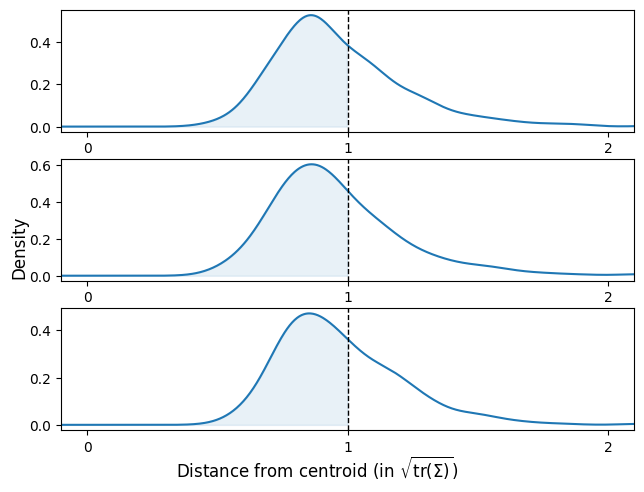

In [5]:
import matplotlib.pyplot as plt
import pandas as pd 

def PlotDensity(n):
    # sort labels by size
    all_labels = list(label_to_distances.keys())
    all_labels = sorted(all_labels, key = lambda x: len(label_to_indices[x]), reverse = True)

    # plot n largest cell types
    plt.close()
    fig, axes = plt.subplots(n, 1)

    print("Percentage of cells within one standard deviation of the mean:")

    for i in range(n):
        label = all_labels[i]
        dists = label_to_distances[label]
        ax = axes[i]

        rad = np.sqrt(label_to_trace[label])

        pd.DataFrame(dists).plot(ax=ax, kind='density', legend=False)
        ax.set_ylabel(None)
        
        colour = ax.lines[-1].get_color()
        line = ax.lines[-1]
        fill_x = line._x
        fill_y = line._y
        
        ax.fill_between(fill_x[fill_x <= rad], 0, fill_y[fill_x <= rad], color=colour, alpha=0.1)
        
        ax.axvline(rad, color='k', linestyle='dashed', linewidth=1)
        
        ax.set_xticks([0, rad, 2*rad], [0, 1, 2])
        ax.set_xlim(-0.1 * rad, 2.1 * rad)

        perc = (np.array(dists) <= rad).sum() / len(dists)
        print(f"Label {label}: {perc*100:.2f}")

    fig.supxlabel("Distance from centroid (in $\sqrt{\mathrm{tr}(Σ)}$)")
    fig.supylabel("Density")
    
    fig.tight_layout(pad=0.2)
    plt.show()

n = 3
PlotDensity(n)